<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220627_future-sales-predict-feature-feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 향후 판매량 예측
 - 과거 판매 데이터를 기반으로 향후 판매량 예측
 - 문제유형 : 회귀
 - 평가지표 : RMSE
 - 사용모델 : LightGBM
 - 훈련/테스트/샘플제출 데이터 이외 3가지 추가데이터

  > shops : 상점에 관한 추가 정보

  > items : 상품에 관한 추가 정보

  > items_categories : 상품분류에 관한 추가 정보

 - 주의 사항 : 각 상점의 상품별 월간 판매량(타깃값)은 0개에서 20개 사이여야 한다

## 베이스라인 모델
 - 베이스라인 모델 : LightGBM
 - 평가지표 계산 함수 : RMSE(사이킷런 제공)

In [135]:
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/predict_future_sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [136]:
# LightGBM으로 범주형 데이터 모델링하면 불필요한 경고문구가 뜸
import warnings
warnings.filterwarnings(action='ignore') # 경고 문구 생략

### 피처 엔지니어링 1 : 피처명 한글화


In [137]:
sales_train = sales_train.rename(columns={'date':'날짜',
                                          'date_block_num':'월ID',
                                          'shop_id':'상점ID',
                                          'item_id':'상품ID',
                                          'item_price':'판매가',
                                          'item_cnt_day':'판매량'}) # rename()함수는 원본데이터 변화X
sales_train.head()

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [138]:
shops = shops.rename(columns={'shop_name':'상점명',
                              'shop_id':'상점ID'})
shops.head()

,상점명,상점ID
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [139]:
items = items.rename(columns={'item_name':'상품명',
                              'item_id':'상품ID',
                              'item_category_id':'상품분류ID'})
items.head()

,상품명,상품ID,상품분류ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [140]:
item_categories = item_categories.rename(columns={'item_category_name':'상품분류명',
                                                  'item_category_id':'상품분류ID'})
item_categories.head()

,상품분류명,상품분류ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [141]:
test = test.rename(columns={'shop_id':'상점ID',
                            'item_id':'상품ID'})
test.head()

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### 피처 엔지니어링 2 : 데이터 다운캐스팅
 - 더 작은 데이터 타입으로 변환
 - 데이터가 작은데 큰데이터 타입 사용시 메모리 낭비
 - 주어진 데이터 크기에 딱 맞는 타입 사용 권장
 - 판다스로 데이터 불러오면(기본설정) : 정수형은 int64, 실수형은 float64
  
  > 각각 정수형, 실수형에서 가장 큰 타입

 - object 타입이면 그대로 둠
 - 불리언 타입이면 int8로 바꿈
 - 정수형 타입이거나 실수형 타입 중 1.0 10.0과 같은 경우 가장작은 정수형 타입으로 바꿈
 - 그외 실수형 타입은 가장작은 실수형 타입으로 바꿈

In [142]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2 # memory_usage() : 피처별 용량(바이트)
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8') # astype() : Series에 적용할 수 있음
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all(): # 피처가 .0으로 만 되어있다면
            df[col] = pd.to_numeric(df[col], downcast='integer') # to_numeric() : 숫자형으로 변환, downcast='integer': 가장작은 정수타입으로
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100*(start_mem-end_mem) / start_mem))
    
    return df


In [143]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)   # 실행되면서 같은 변수에 할당이 되어도 함수 내부의 코드가 유효함

62.5% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


### 피처 엔지니어링 3 : 개별 데이터 피처 엔지니어링

#### sales_train 이상치 제거 및 전처리
 - 판매가, 판매량이 음수라면 환불/오류 : 이상치
 - 판매가가 50,000이상인 데이터 : 이상치
 - 판매량이 1,000이상인 데이터 : 이상치

In [144]:
sales_train = sales_train[sales_train['판매가'] > 0]
sales_train = sales_train[sales_train['판매가'] < 50000]

sales_train = sales_train[sales_train['판매량'] > 0]
sales_train = sales_train[sales_train['판매량'] < 1000]

 - 상점명을 조금 다르게 기입해서 같은 상점이지만 따로 기록돼 있는 상점 네쌍 : 참고한 코드에서 확인

In [145]:
print(shops['상점명'][0], '//', shops['상점명'][57])
print(shops['상점명'][1], '//', shops['상점명'][58])
print(shops['상점명'][10], '//', shops['상점명'][11])
print(shops['상점명'][39], '//', shops['상점명'][40])

!Якутск Орджоникидзе, 56 фран // Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран // Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? // Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" // РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [146]:
# sales_train 데이터에서 상점ID 수정
sales_train.loc[sales_train['상점ID'] == 0, '상점ID'] = 57
sales_train.loc[sales_train['상점ID'] == 1, '상점ID'] = 58
sales_train.loc[sales_train['상점ID'] == 10, '상점ID'] = 11
sales_train.loc[sales_train['상점ID'] == 39, '상점ID'] = 40

# test 데이터에서 상점ID 수정
test.loc[test['상점ID'] == 0, '상점ID'] = 57
test.loc[test['상점ID'] == 1, '상점ID'] = 58
test.loc[test['상점ID'] == 10, '상점ID'] = 11
test.loc[test['상점ID'] == 39, '상점ID'] = 40

#### shops 파생 피처 생성 인코딩
 - 상점명의 첫 단어는 도시
 - 이를 활용해 파생피처 추가

In [147]:
shops['도시'] = shops['상점명'].apply(lambda x: x.split()[0])
# df.apply(함수) : df를 파라미터로 받는 함수 적용
# 함수자리에 lambda 함수사용하여 간략화
# lambda x :  x를 파라미터로 받는 함수

In [148]:
shops['도시'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

##### df.apply(lambda x:) 의미를 풀어보자

In [149]:
def split_test(x):
    return x.split()[0]

In [150]:
shops['상점명'].apply(split_test).unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

 - 도시명 앞의 느낌표(!) 특수문자 오류 : 제거

In [151]:
shops.loc[shops['도시'] == '!Якутск',  '도시'] = 'Якутск'
# shops.loc[shops['도시'].str.startswith('!'), '도시'] = 'Якутск'

In [152]:
shops['도시'].unique()

array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Ярославль'], dtype=object)

 - 도시명은 범주형 피처
 - 머신러닝 모델은 문자를 인식하지 못하므로 숫자로 인코딩 : 레이블 인코딩

  > 레이블 인코딩 주의사항 : 서로 가까운 숫자를 비슷한 데이터로 판단하여 성능에 지장을 줄 수 있음

  > 트리기반 모델 특성상 분기를 반복하여 피처 정보를 반영하므로 레이블 인코딩의 단점이 무마됨

In [153]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 생성
label_encoder = LabelEncoder()

# 도시 피처 레이블 인코딩
shops['도시'] = label_encoder.fit_transform(shops['도시'])

In [154]:
# 상점명 피처 제거
shops = shops.drop('상점명', axis=1)

shops.head()

,상점ID,도시
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


#### items 파생 피처 생성
 - '첫 판매월'  피처 생성
 - '상품ID'와 매칭되는 '상품명' 피처 제거

In [155]:
# 상품명 피처 제거
items = items.drop('상품명', axis=1)

 - 상품이 맨 처음 팔린 월을 새로운 피처로 생성
 - sales_train 데이터 이용

  > 상품ID 기준 그룹화 → 월ID 최솟값

In [156]:
# 상품이 맨 처음 팔린 날을 피처로 추가
items['첫 판매월'] = sales_train.groupby('상품ID').agg({'월ID':min})['월ID']

items.head()

,상품ID,상품분류ID,첫 판매월
0,0,40,20.0
1,1,76,15.0
2,2,40,19.0
3,3,40,18.0
4,4,40,20.0


 - 첫 판매월 피처에 결측값이 있음
 - 한번도 판매된 적이 없다는 뜻

In [157]:
items[items['첫 판매월'].isna()] # isna() : NaN이면 True

,상품ID,상품분류ID,첫 판매월
83,83,40,NaN
140,140,45,NaN
168,168,44,NaN
173,173,45,NaN
204,204,44,NaN
...,...,...,...
21974,21974,61,NaN
21975,21975,61,NaN
22022,22022,40,NaN
22035,22035,40,NaN


 - 368개의 결측값 : 첫 판매월을 test데이터의 타깃값으로 넣어도 무방

In [158]:
items['첫 판매월'] = items['첫 판매월'].fillna(34)

#### item_categories 파생 피처 생성 및 인코딩
 - '대분류'라는 파생피처 생성 -> 인코딩
 - 상품분류명의 첫 단어가 범주 대분류
 - 범주형 데이터가 지나치게 세밀하면(범주별 훈련 데이터 수가 작으면), 훈련이 제대로 되지 않는다.
 - 큰 범주로 묶으면, 범주별 훈련 데이터 수가 많아져서 대분류 수준에서는 예측 정확도가 높아진다.

In [159]:
item_categories['대분류'] = item_categories['상품분류명'].apply(lambda x: x.split()[0])

In [160]:
item_categories['대분류'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: 대분류, dtype: int64

 - 대분류 하나가 범주를 일정개수 이상 가져야 대분류의 의미가 있으며, 성능향상에 유리함
 - 고윳값이 5개 미만인 대분류는 모두 'etc'로 변경

In [161]:
def make_etc(x):
    if item_categories['대분류'].value_counts().to_dict()[x] >= 5:
        # Series -> Dict 형변환 후 키 값으로 Series 데이터를 받음
        return x
    else:
        return 'etc'

# 대분류의 고윳값 개수가 5개 미만이면 etc로 바꾸기
item_categories['대분류'] = item_categories['대분류'].apply(make_etc)

In [162]:
item_categories.head()

,상품분류명,상품분류ID,대분류
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


 - 범주형 피처인 대분류를 인코딩
 - 필요없는 상품분류명 피처는 제거

In [163]:
label_encoder = LabelEncoder()

item_categories['대분류'] = label_encoder.fit_transform(item_categories['대분류'])

item_categories = item_categories.drop('상품분류명', axis=1)

### 피처 엔지니어링 4 : 데이터 조합 및 파생 피처 생성
 - 베이스라인과 같은 방식으로 월ID, 상점ID, 상품ID 조합 생성

In [164]:
from itertools import product

for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID'] == i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID'] == i, '상품ID'].unique()

a = list(product(sales_train['월ID'].unique(), all_shop, all_item))
# [(1,2,3), (1,2,3), (1,2,3), ...] : tuple이 각 행으로 tuple의 각 요소가 각 컬럼으로
'''
 리스트안의 튜플
   [(1,2,3,),
    (1,2,3),
    (1,2,3)] 
'''
idx_features = ['월ID', '상점ID', '상품ID']
train = pd.DataFrame(a, columns=idx_features)
'''
arrary 타입
   [[1,2,3,],
    [1,2,3],
    [1,2,3]]
'''

'\narrary 타입\n   [[1,2,3,],\n    [1,2,3],\n    [1,2,3]]\n'

In [165]:
train.head()

,월ID,상점ID,상품ID
0,0,45,13315
1,0,45,13880
2,0,45,13881
3,0,45,13923
4,0,45,14227


#### 다양한 파생 피처 생성
 - 월ID, 상점ID, 상품ID 별 '월간 판매량', '평균 판매가' 생성

In [166]:
group = sales_train.groupby(idx_features).agg({'판매량':'sum', '판매가':'mean'})

group = group.reset_index()
group = group.rename(columns={'판매량':'월간 판매량', '판매가':'평균 판매가'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가
0,0,45,13315,NaN,NaN
1,0,45,13880,NaN,NaN
2,0,45,13881,2.0,549.0
3,0,45,13923,NaN,NaN
4,0,45,14227,NaN,NaN


 - 결측값은 판매량과 판매가가 0이라는 뜻 : 0으로 대체

 - '기준 피처별 상품 판매건수' : 당일에 한번이라도 팔았다면 1건, 못팔면 0건

In [167]:
# 상품 판매건수 피처 추가
group = sales_train.groupby(idx_features).agg({'판매량':'count'})
group = group.reset_index()
group = group.rename(columns={'판매량':'판매건수'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,45,13315,NaN,NaN,NaN
1,0,45,13880,NaN,NaN,NaN
2,0,45,13881,2.0,549.0,2.0
3,0,45,13923,NaN,NaN,NaN
4,0,45,14227,NaN,NaN,NaN


###  피처 엔지니어링 5 : 데이터 합치기


#### 테스트 데이터 붙이기

In [168]:
test = test.rename(columns={'ID':'월ID'})

In [169]:
# 테스트 데이터 월ID를 34로 설정
test['월ID'] = 34
# train과 test 이어 붙이기
all_data = pd.concat([train, test.drop('월ID', axis=1)],
                            ignore_index=True,
                            keys=idx_features)

# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0.0,45,13315,0.0,0.0,0.0
1,0.0,45,13880,0.0,0.0,0.0
2,0.0,45,13881,2.0,549.0,2.0
3,0.0,45,13923,0.0,0.0,0.0
4,0.0,45,14227,0.0,0.0,0.0


all_data = train에 test데이터를 이어붙임

#### 모든 데이터 병합 및 다운캐스팅

In [170]:
# 나머지 데이터 병합
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

# 데이터 다운캐스팅
all_data = downcast(all_data)

64.1% 압축됨


### 피처 엔지니어링 6 : 시차 피처 생성
 - 시차 피처는 시계열 문제의 성능향상에 도움
 - 기준으로 삼을 피처 : 경진대회 타깃값인 '월간 평균 판매량'

#### 기준 피처별 월간 평균 판매량 파생 피처 생성
 - 1.상점별 월간 평균 판매량
 - 2.상품별 월간 평균 판매량
 - 3.상점별 상품별 월간 평균 판매량


 - 기준 피처로 그룹화해 월간 평균 판매량을 구해주는 함수
```
df : 작업할 전체 데이터(DataFrame)
mean_features : 새로 만든 월간 평균 판매량 파생 피처명을 저장하는 리스트
idx_features : 기준 피처
```



In [171]:
def add_mean_features(df, mean_features, idx_features):
    # 기준 피처 확인
    assert (idx_features[0] == '월ID') and len(idx_features) in [2, 3]
    # assert : 가정설정문(if문, except문을 사용해도 됨), assert이후가 참이여야 진행(False면 에러)

    # 파생 피처명 설정
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '별 평균 판매량'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '별 평균 판매량'
    
    # 기준 피처를 토대로 그룹화해 월간 평균 판매량 구하기
    group = df.groupby(idx_features).agg({'월간 판매량' : 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'월간 판매량' : feature_name})

    # df와 group병합
    df = df.merge(group, on=idx_features, how='left')
    # 데이터 다운캐스팅
    df = downcast(df, verbose=False)

    # 새로 만든 feature_name 피처명을 mean_features 리스트에 추가
    mean_features.append(feature_name)

    return df, mean_features    # 함수를 실행하면서 변수 두개에 나눠 담을 예정

 - ['월ID', '상품ID'] 로 그룹화한 월간 평균판매량
 - ['월ID', '상품ID', '도시'] 로 그룹화한 월간 평균판매량

In [172]:
# '상품ID'가 포함된 파생 피처명을 담을 리스트
item_mean_features = []

#  ['월ID', '상품ID'] 로 그룹화한 월간 평균판매량 파생 피처
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID'])

#  ['월ID', '상품ID', '도시'] 로 그룹화한 월간 평균판매량 파생 피처
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID', '도시'])

In [173]:
item_mean_features

['상품ID별 평균 판매량', '상품ID 도시별 평균 판매량']

 - 추후 이 리스트에 저장된 파생 피처를 활용해 추가적인 피처 엔지니어링 적용 : 시차 피처 생성

 - ['월ID', '상점ID', '상품분류ID']로 그룹화한 월간 평균판매량

In [174]:
# '상점ID'가 포함된 파생 피처명을 담을 리스트
shop_mean_features = []

# ['월ID', '상점ID', '상품분류ID']로 그룹화한 월간 평균판매량 파생 피처
all_data, shop_mean_features = add_mean_features(df=all_data,
                                                 mean_features=shop_mean_features,
                                                 idx_features=['월ID', '상점ID', '상품분류ID'])

In [175]:
shop_mean_features

['상점ID 상품분류ID별 평균 판매량']

#### 시차 피처 생성 원리 및 함수 구현
 - 지금까지 만든 기준 피처별 월간 평균 판매량 피처
  
  > 1.상품ID별 평균 판매량

  > 2.상품ID + 도시별 평균 판매량

  > 3.상품ID + 상품범주별 평균 판매량

 - 현시점 데이터에 과거 시점 데이터를 추가하는 개념
 - 시점이 너무 과거인 경우 예측력이 오히려 떨어짐

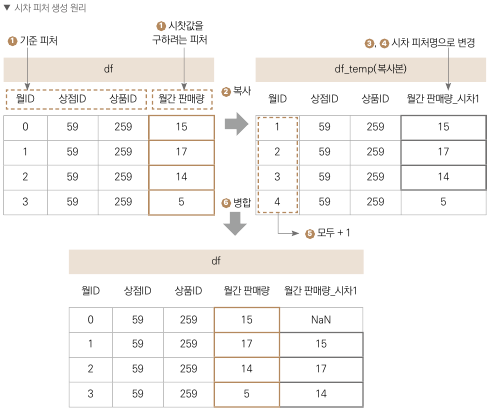

 - add_lag_features() : 시차 피처를 추가하는 함수
 - 파라미터

  > df : 원본데이터

  > lag_features_to_clip : '값의 범위를 0~20사이로 제한할 피처'를 담을 리스트

  > idx_features : 기준 피처

  > lag_feature : 시차를 만들 피처

  > nlags : 시차
   - 1 = 한 달 전 시차 피처만 생성
   - 2 = 한 달 전, 두 달 전 시차 피처 생성
   - 3 = 한 달 전, 두 달 전, 세 달 전 시차 피처 생성
  
  > clip : 새로 만들 시차 피처를 lag_features_to_clip 리스트에 저장할 지 여부(True/False)

In [176]:
def add_lag_features(df, lag_features_to_clip, idx_features,
                     lag_feature, nlags=3, clip=False):
    # 시차 피처 생성에 필요한 DatfaFrame 부분만 복사
    df_temp = df[idx_features + [lag_feature]].copy()
    # 리스트와 문자열은 바로 합칠 수 없다 → 리스트 + [문자열]

    # 시차 피처 생성
    for i in range(1, nlags+1):
        # 시차 피처명
        lag_feature_name = lag_feature + '_시차' + str(i)
        # df_temp 열 이름 설정
        df_temp.columns = idx_features + [lag_feature_name]
        # df_temp의 date_block_num 피처에 i 더하기
        df_temp['월ID'] += i
        # idx_feature를 기준으로 df와 df_temp 병합하기
        df = df.merge(df_temp.drop_duplicates(),
                      on=idx_features,
                      how='left')
        # 결측값 0으로 대체
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # 0~20 사이로 세한할 시차 피처명을 lag_features_to_clip에 추가
        if clip:
            lag_features_to_clip.append(lag_feature_name)

    # 데이터 다운캐스팅
    df = downcast(df, False)

    return df, lag_features_to_clip

#### 시차 피처 생성 1 : 월간 판매량
 - 기준피처 : '월ID', '상점ID', '상품ID'
 - 월간 판매량의 세달치 파생 피처 생성

In [177]:
lag_features_to_clip = [] # 0~20 사이로 제한할 시차 피처명을 담을 리스트
idx_features = ['월ID', '상점ID', '상품ID']

# idx_features를 기준으로 월간 판매량의 세달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='월간 판매량',
                                                  nlags=3,
                                                  clip=True)    # 값을 0~20 사이로 제한

In [178]:
all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수,도시,상품분류ID,첫 판매월,대분류,상품ID별 평균 판매량,상품ID 도시별 평균 판매량,상점ID 상품분류ID별 평균 판매량,월간 판매량_시차1,월간 판매량_시차2,월간 판매량_시차3
0,0,45,13315,0,0.0,0,20,47,31,6,0.000000,0.00,0.000000,0,0,0
1,0,45,13880,0,0.0,0,20,55,21,7,0.000000,0.00,0.060358,0,0,0
2,0,45,13881,2,549.0,2,20,55,0,7,1.360465,0.50,0.060358,0,0,0
3,0,45,13923,0,0.0,0,20,40,0,5,0.500000,0.25,0.034018,0,0,0
4,0,45,14227,0,0.0,0,20,30,10,3,0.000000,0.00,0.411150,0,0,0


In [179]:
lag_features_to_clip

['월간 판매량_시차1', '월간 판매량_시차2', '월간 판매량_시차3']

 - 새로 만든 세 피처의 이름은 lag_features_to_clip에 저장됨

#### 시차 피처 생성 2 : 판매 건수, 평균 판매가
 - 타깃값이 아니기때문에 0~20사이로 제한할 필요X

In [180]:
# idx_features를 기준으로 판매 건수의 세달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='판매건수',
                                                  nlags=3,
                                                  clip=False)    # 값을 0~20 사이로 제한
                                                
# idx_features를 기준으로 평균 판매가 피처의 세달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='평균 판매가',
                                                  nlags=3,
                                                  clip=False)    # 값을 0~20 사이로 제한

### 시차 피처 생성 3 : 평균 판매량

 - item_mean_features에 저장된 ['상품ID별 평균 판매량', '상품ID 도시별 평균 판매량']
 - 두 피처 값에 대해 시차 피처생성

In [181]:
# idx_features를 기준으로 item_mean_features 요소별 시차 피처 생성
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                    lag_features_to_clip=lag_features_to_clip,
                                                    idx_features=idx_features,
                                                    lag_feature=item_mean_feature,
                                                    nlags=3,
                                                    clip=True)    # 값을 0~20 사이로 제한

In [182]:
# 시차 피처 만든 후 all_data에서 item_mean_features에 저장된 피처 제거
# 이 피처들은 시차 피처를 만드는데 필요할 뿐 모델링에 사용하지 않음
all_data = all_data.drop(item_mean_features, axis=1)
all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수,도시,상품분류ID,첫 판매월,대분류,...,판매건수_시차3,평균 판매가_시차1,평균 판매가_시차2,평균 판매가_시차3,상품ID별 평균 판매량_시차1,상품ID별 평균 판매량_시차2,상품ID별 평균 판매량_시차3,상품ID 도시별 평균 판매량_시차1,상품ID 도시별 평균 판매량_시차2,상품ID 도시별 평균 판매량_시차3
0,0,45,13315,0,0.0,0,20,47,31,6,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,45,13880,0,0.0,0,20,55,21,7,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,45,13881,2,549.0,2,20,55,0,7,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,45,13923,0,0.0,0,20,40,0,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,45,14227,0,0.0,0,20,30,10,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 - shop_mean_features에 저장된 ['상점ID 상품분류ID별 평균 판매량']

In [183]:
# ['월ID', '상점ID', '상품분류ID']를 기준으로
# shop_mean_features 요소별 시차 피처 생성
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                    lag_features_to_clip=lag_features_to_clip,
                                                    idx_features=['월ID', '상점ID', '상품분류ID'],
                                                    lag_feature=shop_mean_feature,
                                                    nlags=3,
                                                    clip=True)    # 값을 0~20 사이로 제한
# shop_mean_features 피처 제거
all_data = all_data.drop(shop_mean_features, axis=1)

#### 시차 피처 생성 마무리 : 결측값 처리


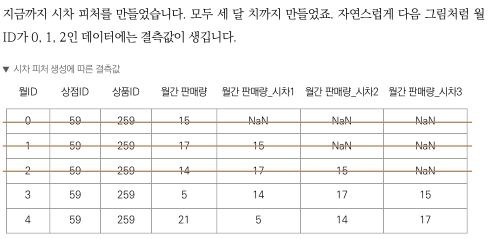

 - 결측값을 없대려면 월ID가 3미만인 데이터 제거

In [184]:
# df.drop() 사용방법
# column 제거
# df.drop(columns=[컬럼명], axis=1)
# row 제거
# df.drop(df[조건].index)

# df의 조건으로 필터링
# df[조건]
# df.loc[조건, '컬럼명'] : 조건에 맞는 해당 컬럼만 가져옴

In [185]:
all_data[all_data['월ID'] < 3].index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            8460435, 8460436, 8460437, 8460438, 8460439, 8460440, 8460441,
            8460442, 8460443, 8460444],
           dtype='int64', length=978915)

In [186]:
all_data = all_data.drop(all_data[all_data['월ID'] < 3].index) # df[조건].index : 조건에 맞는 인덱스

### 피처 엔지니어링 7 : 기타 피처 엔지니어링

#### 기타 피처 추가
 - 1. 월간 판매량 시차 피처들의 평균

In [187]:
all_data[['월간 판매량_시차1', '월간 판매량_시차2', '월간 판매량_시차3']]

,월간 판매량_시차1,월간 판매량_시차2,월간 판매량_시차3
764715,0,0,0
764716,0,0,0
764717,1,2,0
764718,1,2,0
764719,1,2,0
...,...,...,...
8246240,0,0,0
8246241,0,0,0
8246242,0,0,0
8246243,0,0,0


In [188]:
all_data[['월간 판매량_시차1', '월간 판매량_시차2', '월간 판매량_시차3']].mean()

월간 판매량_시차1    0.241759
월간 판매량_시차2    0.225869
월간 판매량_시차3    0.194608
dtype: float64

In [189]:
all_data[['월간 판매량_시차1', '월간 판매량_시차2', '월간 판매량_시차3']].mean(axis=1)

764715     0.0
764716     0.0
764717     1.0
764718     1.0
764719     1.0
          ... 
8246240    0.0
8246241    0.0
8246242    0.0
8246243    0.0
8246244    0.0
Length: 7481530, dtype: float64

In [190]:
all_data['월간 판매량 시차평균'] = all_data[['월간 판매량_시차1',
                                             '월간 판매량_시차2',
                                             '월간 판매량_시차3']].mean(axis=1)

 - 이 피처도 판매량과 관련되어 있으므로 0~20 사이로 조정

In [191]:
lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']

['월간 판매량_시차1',
 '월간 판매량_시차2',
 '월간 판매량_시차3',
 '상품ID별 평균 판매량_시차1',
 '상품ID별 평균 판매량_시차2',
 '상품ID별 평균 판매량_시차3',
 '상품ID 도시별 평균 판매량_시차1',
 '상품ID 도시별 평균 판매량_시차2',
 '상품ID 도시별 평균 판매량_시차3',
 '상점ID 상품분류ID별 평균 판매량_시차1',
 '상점ID 상품분류ID별 평균 판매량_시차2',
 '상점ID 상품분류ID별 평균 판매량_시차3',
 '월간 판매량',
 '월간 판매량 시차평균']

In [192]:
# 0~20 사이로 값 제한
all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']] = \
all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']].clip(0,20)

 - 2. 시차 변화량

  > 시차변화량1 = 월간 판매량_시차1 / 월간 판매량_시차2

  > 시차변화량2 = 월간 판매량_시차2 / 월간 판매량_시차3

In [193]:
import numpy as np
all_data['시차변화량1'] = all_data['월간 판매량_시차1'] / all_data['월간 판매량_시차2']
# 나누기를 하다보면 무한대, -무한대 값이 생기게 되므로 np.nan으로 대체후 0을 fill
all_data['시차변화량1'] = all_data['시차변화량1'].replace([np.inf, -np.inf], np.nan).fillna(0)

all_data['시차변화량2'] = all_data['월간 판매량_시차2'] / all_data['월간 판매량_시차3']
all_data['시차변화량2'] = all_data['시차변화량2'].replace([np.inf, -np.inf], np.nan).fillna(0)


 - 3. 신상 여부 : 첫 판매월이 현재 월과 같다면 신상품

In [194]:
all_data['신상여부'] = all_data['첫 판매월'] == all_data['월ID'] # True / False

In [195]:
all_data['신상여부']

764715     False
764716     False
764717     False
764718     False
764719     False
           ...  
8246240     True
8246241    False
8246242     True
8246243    False
8246244    False
Name: 신상여부, Length: 7481530, dtype: bool

 - 4. 첫 판매 후 경과 기간

In [196]:
all_data['첫 펀매 후 기간'] = all_data['월ID'] - all_data['첫 판매월']

 - 5. 월(month)

In [197]:
all_data['월'] = all_data['월ID'] % 12 # 12로 나눈 나머지가 월

#### 필요 없는 피처 제거

In [198]:
# 첫 판매월, 평균 판매가, 판매건수 피처 제거
all_data = all_data.drop(columns=['첫 판매월', '평균 판매가', '판매건수'], axis=1)

In [199]:
all_data = downcast(all_data, False)

### 피처 엔지니어링 7 : 마무리

In [200]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7481530 entries, 764715 to 8246244
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   월ID                      int8   
 1   상점ID                     int8   
 2   상품ID                     int16  
 3   월간 판매량                   int8   
 4   도시                       int8   
 5   상품분류ID                   int8   
 6   대분류                      int8   
 7   월간 판매량_시차1               int8   
 8   월간 판매량_시차2               int8   
 9   월간 판매량_시차3               int8   
 10  판매건수_시차1                 int8   
 11  판매건수_시차2                 int8   
 12  판매건수_시차3                 int8   
 13  평균 판매가_시차1               float32
 14  평균 판매가_시차2               float32
 15  평균 판매가_시차3               float32
 16  상품ID별 평균 판매량_시차1         float32
 17  상품ID별 평균 판매량_시차2         float32
 18  상품ID별 평균 판매량_시차3         float32
 19  상품ID 도시별 평균 판매량_시차1      float32
 20  상품ID 도시별 평균 판매량_시차2      float32
 21  상품I